In [1]:
# Total Exchange Flow (TEF) Calculation  (MacCready, 2011)
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import TEF_Variables as tef
sys.path.append(os.path.abspath('../Functions'))
import ExchangeFlow2 as exg 

In [2]:
# Load fields
Qsg = 700
hs = 12
State = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/qf' + str(format(Qsg,'03d')) + '_rot/state_' + str(format(hs,'03d')) + '.nc')
Grid = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/qf' + str(format(Qsg,'03d')) + '_rot/grid_' + str(format(hs,'03d')) + '.nc')
# Confine to the range of fjord
state = State.isel(X=range(120), Xp1=range(121), Y=range(30,39), T=range(1,len(State.T)))
grid = Grid.isel(X=range(120), Xp1=range(121), Y=range(30,39))


s = state.S.data.mean(2) # Salinity in T,Z,X
u = (state.U.data[:,:,:,1:].mean(2) + state.U.data[:,:,:,:-1].mean(2)) / 2 # Along channel velocity
ot = state.T.data # Time in seconds


x = grid.X.data
z = grid.Z.data
NY = len(state.Y)

HFacC1 = grid.HFacC.data.mean(1)
dyF1 = grid.dyF.data.mean(0)
drF1 = grid.drF.data
gridA = np.broadcast_to(drF1[:, np.newaxis], HFacC1.shape) * np.broadcast_to(dyF1[np.newaxis, :], HFacC1.shape) * HFacC1 # Grid Area
da = np.broadcast_to(gridA[np.newaxis,:,:], u.shape)

S = state.S.data
U = (state.U.data[:,:,:,1:] + state.U.data[:,:,:,:-1]) / 2
drF = np.broadcast_to(grid.drF.data[np.newaxis, :, np.newaxis, np.newaxis], U.shape)
dyF = np.broadcast_to(grid.dyF.data[np.newaxis, np.newaxis, :, :], U.shape)
HFacC = np.broadcast_to(grid.HFacC.data[np.newaxis, :, :, :], U.shape)
DA = drF * dyF * HFacC



In [3]:
da[:,:,22], 

(array([[ 100.        ,  100.        ,  100.        , ..., 1600.        ,
         1600.        , 1599.99999937],
        [ 100.        ,  100.        ,  100.        , ..., 1600.        ,
         1600.        , 1599.99999937],
        [ 100.        ,  100.        ,  100.        , ..., 1600.        ,
         1600.        , 1599.99999937],
        ...,
        [ 100.        ,  100.        ,  100.        , ..., 1600.        ,
         1600.        , 1599.99999937],
        [ 100.        ,  100.        ,  100.        , ..., 1600.        ,
         1600.        , 1599.99999937],
        [ 100.        ,  100.        ,  100.        , ..., 1600.        ,
         1600.        , 1599.99999937]]),)

  time 0 out of 336


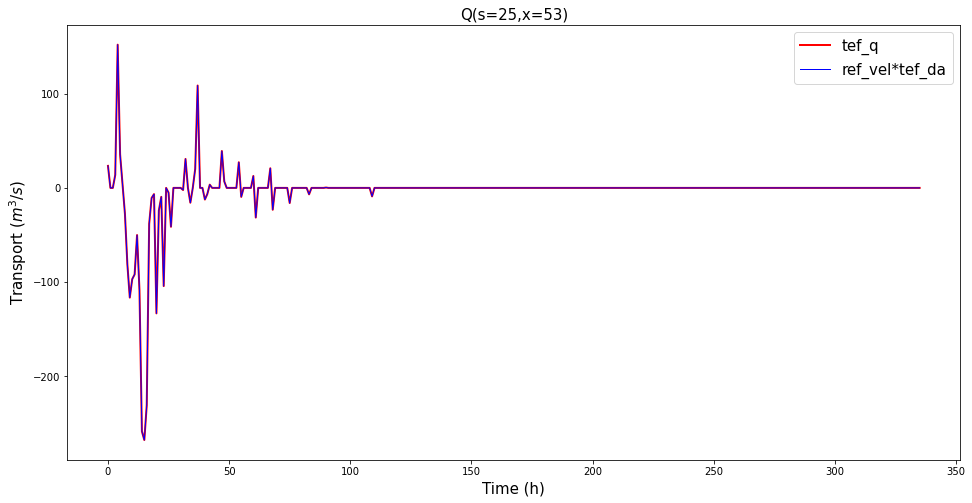

In [4]:
xi = 53

tef_q, tef_vel, tef_da, tef_qs, tef_qs2, sbins = tef.process_section(U,S,DA,ot,xi,25,testing=True)

In [5]:
qin, qout, sin, sout = tef.bulk_calc(tef_q, tef_vel, tef_da, tef_qs, tef_qs2, sbins, ot)

/Users/weiyangbao/Documents/Jupyter-Iceplume/TEF/TEF_Variables.py:269: RuntimeWarning: invalid value encountered in true_divide
  Sm = QSm/Qm
/Users/weiyangbao/Documents/Jupyter-Iceplume/TEF/TEF_Variables.py:273: RuntimeWarning: invalid value encountered in true_divide
  S2m = QS2m/Qm


Text(0.5, 0, 'Time (h)')

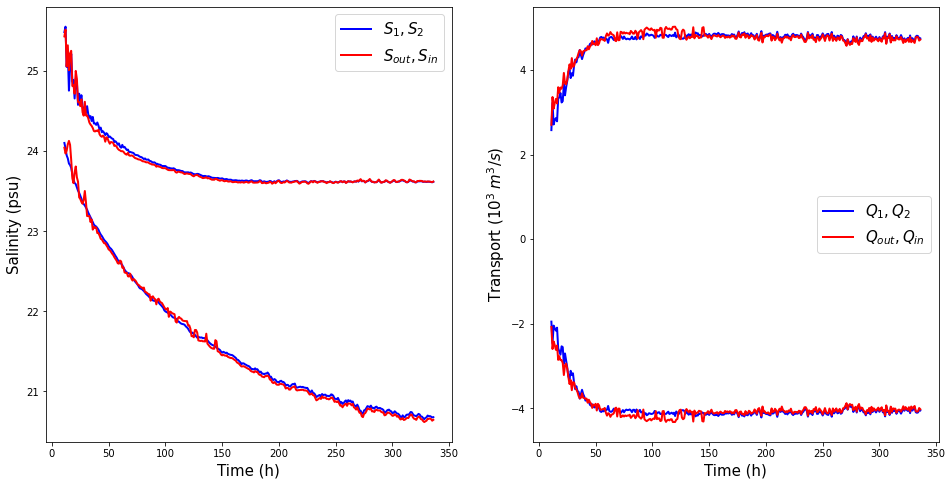

In [6]:
q1, q2, s1, s2 = exg.ef_Eu(U,S,DA,xi)

fig1 = plt.figure(figsize=(16,8))
fig1.tight_layout()

ax1 = fig1.add_subplot(121)
ax1.plot(ot[10:]/3600,s1[10:],'b-',lw=2,label=r'$S_1, S_2$')
ax1.plot(ot[10:]/3600,sin[10:],'r-',lw=2,label=r'$S_{out},S_{in}$')
ax1.plot(ot[10:]/3600,s2[10:],'b-',lw=2,)
ax1.plot(ot[10:]/3600,sout[10:],'r-',lw=2)
ax1.legend(loc='best', fontsize=15)
ax1.set_ylabel(r'Salinity (psu)',size = 15)
ax1.set_xlabel(r'Time (h)', size = 15)

ax2 = fig1.add_subplot(122)
ax2.plot(ot[10:]/3600,q1[10:]/1e3,'b-',lw=2,label=r'$Q_1,Q_2$')
ax2.plot(ot[10:]/3600,qin[10:]/1e3,'r-',lw=2,label=r'$Q_{out},Q_{in}$')
ax2.plot(ot[10:]/3600,q2[10:]/1e3,'b-',lw=2)
ax2.plot(ot[10:]/3600,qout[10:]/1e3,'r-',lw=2)
ax2.legend(loc='best', fontsize=15)
ax2.set_ylabel(r'Transport ($10^3\;m^3/s$)',size = 15)
ax2.set_xlabel(r'Time (h)', size = 15)

21.199906646228225 20.734521822850986 20.699166065488374 23.660730312609324 23.621043685691507 23.623726083498248


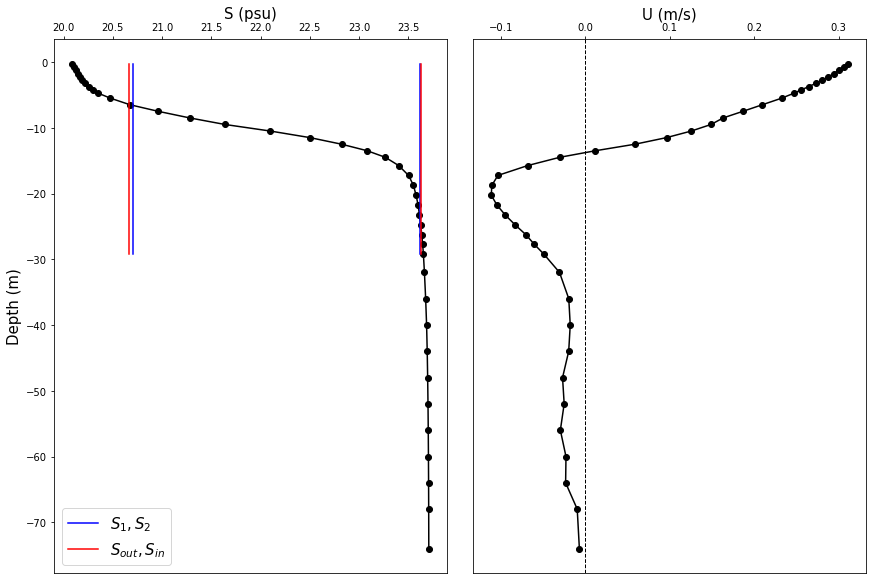

In [7]:
Sma = np.ma.masked_where(s==0, s)
topo = np.ma.getmask(Sma)
Uma = np.ma.MaskedArray(u, mask=topo)

ch = grid.drF.data * grid.HFacC.data[:,:,xi].mean(1)# Cell height
Sm = np.sum(Sma[275:,:,xi].mean(0) * ch) / ch.sum()
Sm1 = np.sum(Sma[275:,:19,xi].mean(0) * ch[:19]) / ch[:19].sum()
Sm2 = np.sum(Sma[275:,19:,xi].mean(0) * ch[19:]) / ch[19:].sum()
Se = (sin[275:].mean() + sout[275:].mean()) / 2
Sv = (s1[275:].mean() + s2[275:].mean()) / 2
# Two-panel plot
fig2, (ax1, ax2) = plt.subplots(1,2,sharey=True, figsize=(12,8))
fig2.tight_layout()

# Salinity
ax1.plot(Sma[300:,:,xi].mean(0),z,'o-k')
#ax1.axvline(x=23.2, color='k',lw=1,linestyle='--')
ax1.set_ylabel('Depth (m)',size = 15)

dep = z[:30]
S1m = np.ones(len(dep)) * s1[300:].mean()
Sin = np.ones(len(dep)) * sin[300:].mean()
S2m = np.ones(len(dep)) * s2[300:].mean()
Sout = np.ones(len(dep)) * sout[300:].mean()

ax1.plot(S1m,dep,'b-', label=r'$S_1,S_2$')
ax1.plot(Sin,dep,'r-', label=r'$S_{out},S_{in}$')
ax1.plot(S2m,dep,'b-')
ax1.plot(Sout,dep,'r-')
ax1.legend(loc='best', fontsize=15)


#ax1.set_ylim(ax2.get_ylim()[::-1]) #this reverses the yaxis (i.e. deep at the bottom)
ax1.set_xlabel('S (psu)', size = 15)
ax1.xaxis.set_label_position('top') # this moves the label to the top
ax1.xaxis.set_ticks_position('top') # this moves the ticks to the top
# Along-channel velocity
ax2.plot(Uma[300:,:,xi].mean(0),z,'o-k')
ax2.axvline(x=0, color='k',lw=1,linestyle='--')
#ax2.legend(fontsize=15)
ax2.set_xlabel('U (m/s)', size = 15)
ax2.xaxis.set_label_position('top') # this moves the label to the top
ax2.xaxis.set_ticks_position('top') # this moves the ticks to the top
ax2.yaxis.set_visible(False) # This erases the y ticks

print(Sm1, s1[275:].mean(), sin[275:].mean(), Sm2, s2[275:].mean(), sout[275:].mean())

In [8]:
ux = Uma[250,:,xi]
ax = da[250,:,xi]
sx = Sma[250,:,xi]
qx = ux * ax
qsx = ux * ax * sx


sa = sx[:19]*ax[:19]*ux[:19]
A = ax[:19]*ux[:19]
sx1 = sa.sum() / A.sum() 
qsp = qsx[qsx>0].sum()
qp = qx[qx>0].sum()
sout1 = qsp /qp

ux[:19] / ux[:19]

masked_array(data=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,
                   1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False],
       fill_value=1e+20,
            dtype=float32)

In [9]:
state.S

<xarray.DataArray 'S' (T: 336, Z: 50, Y: 9, X: 120)>
array([[[[ 0.      , ..., 25.021486],
         ...,
         [ 0.      , ..., 25.021488]],

        ...,

        [[ 0.      , ..., 34.73176 ],
         ...,
         [ 0.      , ..., 34.732014]]],


       ...,


       [[[ 0.      , ..., 20.06708 ],
         ...,
         [ 0.      , ..., 20.365768]],

        ...,

        [[ 0.      , ..., 34.623554],
         ...,
         [ 0.      , ..., 34.623478]]]], dtype=float32)
Coordinates:
  * Y        (Y) float64 2.25e+04 2.27e+04 2.29e+04 ... 2.39e+04 2.41e+04
  * Z        (Z) float64 -0.25 -0.75 -1.25 -1.75 ... -122.0 -130.0 -138.0 -146.0
  * X        (X) float64 50.0 150.0 250.0 ... 8.822e+03 8.922e+03 9.022e+03
  * T        (T) float64 3.6e+03 7.2e+03 1.08e+04 ... 1.206e+06 1.21e+06
Attributes:
    long_name:    salinity
    coordinates:  XC YC RC iter